# Setup

## Import and check packages

In [1]:
import sys
import pandas as pd
import numpy as np
import nltk
import gensim
import sklearn
import re, string
from nltk.stem import PorterStemmer
import multiprocessing
import os
import csv
import matplotlib

In [2]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, \
                                            CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
print('Version check:')
print('Python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('nltk: {}'.format(nltk.__version__))
print('gensim: {}'.format(gensim.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('regex: {}'.format(re.__version__))

Version check:
Python: 3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]
pandas: 1.0.3
nltk: 3.5
gensim: 3.8.3
sklearn: 0.22.2.post1
regex: 2.2.1


## Import data

In [4]:
# train_df = pd.read_pickle('data_files/train_df.pkl')
# train_df.head()

In [5]:
# test_df = pd.read_pickle('data_files/test_df.pkl')
# test_df.head()

In [6]:
df = pd.read_pickle('data_files/shuffled_df.pkl')
shuffled_df = df.sample(frac=1)
shuffled_df.head()

,,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,review_word_count
7392,3326,on 06/07/06 15:54 PM (PDT),Trudy Case,2005 Pontiac Vibe Wagon AWD 4dr Wagon (1.8L 4c...,My opinions after 9 months of ownership,Style-AWD wagon Overall a very nice car that ...,4.5,684
1789,3175,on 02/17/04 00:00 AM (PST),Maggielu,1999 Subaru Legacy Wagon Outback 4dr Wagon AWD,Transmission issues,"Transmission going at 85,000 miles. \nHeard ...",2.625,325
7920,3782,on 12/29/06 20:07 PM (PST),grocerygetten,2007 Subaru Forester Wagon 2.5 X 4dr Wagon AWD...,love it,I love this car. Got 8 inches of snow 1 week ...,5,299
443,1660,on 05/12/09 11:48 AM (PDT),Bill Bates,2007 Subaru B9 Tribeca SUV Ltd. 5-Pass. 4dr SU...,Aceleration,The editors review indicated less than good a...,4.75,242
6342,591,on 10/11/02 00:00 AM (PDT),EclipseGuy,1997 Mitsubishi Eclipse Hatchback GS 2dr Hatch...,great car!!!,"Really great car, love the exterior and \nthe...",5,85


In [7]:
shuffled_df.dtypes

                     object
Review_Date          object
Author_Name          object
Vehicle_Title        object
Review_Title         object
Review               object
Rating               object
review_word_count     int64
dtype: object

In [8]:
shuffled_df.Rating = shuffled_df.Rating.astype('float')

In [9]:
shuffled_df.dtypes

                      object
Review_Date           object
Author_Name           object
Vehicle_Title         object
Review_Title          object
Review                object
Rating               float64
review_word_count      int64
dtype: object

In [10]:
shuffled_df['rounded_rating'] = shuffled_df.Rating.round(0)

In [11]:
shuffled_df.head()

,,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,review_word_count,rounded_rating
7392,3326,on 06/07/06 15:54 PM (PDT),Trudy Case,2005 Pontiac Vibe Wagon AWD 4dr Wagon (1.8L 4c...,My opinions after 9 months of ownership,Style-AWD wagon Overall a very nice car that ...,4.500,684,4.0
1789,3175,on 02/17/04 00:00 AM (PST),Maggielu,1999 Subaru Legacy Wagon Outback 4dr Wagon AWD,Transmission issues,"Transmission going at 85,000 miles. \nHeard ...",2.625,325,3.0
7920,3782,on 12/29/06 20:07 PM (PST),grocerygetten,2007 Subaru Forester Wagon 2.5 X 4dr Wagon AWD...,love it,I love this car. Got 8 inches of snow 1 week ...,5.000,299,5.0
443,1660,on 05/12/09 11:48 AM (PDT),Bill Bates,2007 Subaru B9 Tribeca SUV Ltd. 5-Pass. 4dr SU...,Aceleration,The editors review indicated less than good a...,4.750,242,5.0
6342,591,on 10/11/02 00:00 AM (PDT),EclipseGuy,1997 Mitsubishi Eclipse Hatchback GS 2dr Hatch...,great car!!!,"Really great car, love the exterior and \nthe...",5.000,85,5.0


In [12]:
shuffled_df.columns

Index(['', 'Review_Date', 'Author_Name', 'Vehicle_Title', 'Review_Title',
       'Review', 'Rating', 'review_word_count', 'rounded_rating'],
      dtype='object')

In [13]:
shuffled_df.rounded_rating.value_counts()

5.0    8559
4.0    5225
3.0    1396
2.0     725
1.0     211
Name: rounded_rating, dtype: int64

## Setup functions

In [14]:
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

## Analysis settings

In [15]:
n_dim = 100
n_grams = 1
random_seed = 88
cores = multiprocessing.cpu_count()
STEMMING = True

## Sample documents

In [16]:
shuffled_df = shuffled_df.iloc[:1500]

# Vectorize Data

## Prepare data

In [17]:
# train_docs = list()
# gensim_train = list()
# for i in range(len(train_df)):
#     temp_text = train_df['Review'].iloc[i]
#     cleaned_doc = clean_doc(temp_text)
#     gensim_train.append(cleaned_doc)
#     #print(temp_text)
#     combined_text = ' '.join(clean_doc(temp_text))
#     train_docs.append(combined_text)

In [18]:
# test_docs = list()
# gensim_test = list()
# for i in range(len(test_df)):
#     temp_text = train_df['Review'].iloc[i]
#     cleaned_doc = clean_doc(temp_text)
#     gensim_test.append(cleaned_doc)
#     #print(temp_text)
#     combined_text = ' '.join(clean_doc(temp_text))
#     test_docs.append(combined_text)

In [19]:
docs = list()
gensim_docs = list()

for i in range(len(shuffled_df)):
    temp_text = shuffled_df['Review'].iloc[i]
    cleaned_doc = clean_doc(temp_text)
    gensim_docs.append(cleaned_doc)
    #print(temp_text)
    combined_text = ' '.join(clean_doc(temp_text))
    docs.append(combined_text)

## CountVectorizer

In [20]:
count_vec = CountVectorizer(ngram_range=(1, 1), max_features=100)
count_matrix = count_vec.fit_transform(docs)

In [21]:
count_matrix[0].toarray()

array([[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0]])

In [22]:
print(count_vec.get_feature_names()[:5])

['acceler', 'almost', 'anoth', 'around', 'averag']


## TF-IDF

In [23]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), max_features=100)
tfidf_matrix =tfidf_vec.fit_transform(docs)

In [24]:
tfidf_vec.get_feature_names()[:5]

['acceler', 'almost', 'anoth', 'around', 'averag']

In [26]:
tfidf_matrix.T[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [27]:
len(tfidf_vec.get_feature_names())

100

## Doc2Vec

In [28]:
train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(gensim_docs)]
cores = multiprocessing.cpu_count()

print("\nWorking on Doc2Vec vectorization, dimension 100")
model_100 = Doc2Vec(train_corpus, vector_size = 100, window = 4, 
	min_count = 1, workers = cores, epochs = 20)

model_100.train(train_corpus, total_examples = model_100.corpus_count, 
	epochs = model_100.epochs)  # build vectorization model on training set

# vectorization for the training set
doc2vec_100_vectors = np.zeros((len(gensim_docs), 100)) # initialize numpy array
for i in range(0, len(gensim_docs)):
    doc2vec_100_vectors[i,] = model_100.infer_vector(gensim_docs[i]).transpose()
print('\nTraining doc2vec_100_vectors.shape:', doc2vec_100_vectors.shape)
# print('doc2vec_100_vectors[:2]:', doc2vec_100_vectors[:2])

# vectorization for the test set
# doc2vec_100_vectors_test = np.zeros((len(gensim_test), 100)) # initialize numpy array
# for i in range(0, len(gensim_test)):
#     doc2vec_100_vectors_test[i,] = model_100.infer_vector(gensim_test[i]).transpose()
# print('\nTest doc2vec_100_vectors_test.shape:', doc2vec_100_vectors_test.shape)


Working on Doc2Vec vectorization, dimension 100

Training doc2vec_100_vectors.shape: (1500, 100)


In [29]:
type(doc2vec_100_vectors)

numpy.ndarray

# Clustering Analysis

## CountVectorizer

In [30]:
shuffled_df.columns

Index(['', 'Review_Date', 'Author_Name', 'Vehicle_Title', 'Review_Title',
       'Review', 'Rating', 'review_word_count', 'rounded_rating'],
      dtype='object')

In [31]:
k=5 # for the number of stars given to each review
km = KMeans(n_clusters=k, random_state =random_seed)
km.fit(count_matrix)
clusters = km.labels_.tolist()

terms = count_vec.get_feature_names()
Dictionary={'Cluster':clusters, 'Text': docs, 'Rating' : shuffled_df.rounded_rating.iloc[:1500]}
frame=pd.DataFrame(Dictionary, columns=['Rating', 'Cluster','Text'])
frame['record']=1
frame.head(n=10)

,Rating,Cluster,Text,record
7392,4.0,2,styleawd wagon overal need perfectli cargo use...,1
1789,3.0,0,transmiss go mile heard issu subaru admit prob...,1
7920,5.0,4,inch bought great handl dream plenti look grea...,1
443,5.0,2,editor review indic acceler tribeca disagre st...,1
6342,5.0,2,realli great exterior realli handl corner,1
7488,5.0,2,great except thing brake track light come seem...,1
13573,5.0,4,mile love everyth look great nimbl handl exter...,1
7730,5.0,3,alway like adventur vehicl outback someth vers...,1
268,5.0,4,trade passat beat passat almost everi handl ac...,1
4379,5.0,0,bought mile problem replac brake that couldnt ...,1


In [32]:
frame[frame.Cluster == 3].Rating.mean()

4.514285714285714

In [33]:
frame[frame.Cluster == 0].Rating.mean()

3.8266129032258065

In [34]:
frame[frame.Cluster == 1].Rating.mean()

3.7857142857142856

In [35]:
frame[frame.Cluster == 2].Rating.mean()

4.377049180327869

In [36]:
frame[frame.Cluster == 4].Rating.mean()

4.651282051282052

In [37]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms

Top terms per cluster:
Cluster 0:
 mile
 replac
 problem
 bought
 engin
 year
 still
 brake
 drive
 subaru
Cluster 1:
 subaru
 drive
 vehicl
 would
 seat
 engin
 mile
 comfort
 great
 still
Cluster 2:
 drive
 vehicl
 great
 look
 power
 handl
 would
 problem
 mile
 subaru
Cluster 3:
 drive
 great
 vehicl
 handl
 power
 mile
 problem
 look
 engin
 comfort
Cluster 4:
 great
 drive
 look
 handl
 bought
 mileag
 mile
 power
 vehicl
 realli


In [38]:
pivot=pd.pivot_table(frame, values='record', index='Rating',
                     columns='Cluster', aggfunc=np.sum, fill_value=0)

pivot.head(n=25)

Cluster,0,1,2,3,4
Rating,,,,,
1.0,4,5,9,2,0
2.0,25,1,23,2,1
3.0,48,2,71,7,7
4.0,104,7,285,57,51
5.0,67,13,466,107,136


## TF-IDF

In [39]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################
#### Note: Here we carry out a clustering of the documents
k=5
km = KMeans(n_clusters=k, random_state =random_seed)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

terms = tfidf_vec.get_feature_names()
Dictionary={'Cluster':clusters, 'Text': docs, 'Rating' : shuffled_df.rounded_rating.iloc[:1500]}
frame=pd.DataFrame(Dictionary, columns=['Rating', 'Cluster','Text'])
frame['record']=1
frame.head()

,Rating,Cluster,Text,record
7392,4.0,0,styleawd wagon overal need perfectli cargo use...,1
1789,3.0,2,transmiss go mile heard issu subaru admit prob...,1
7920,5.0,3,inch bought great handl dream plenti look grea...,1
443,5.0,3,editor review indic acceler tribeca disagre st...,1
6342,5.0,3,realli great exterior realli handl corner,1


In [40]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms

Top terms per cluster:
Cluster 0:
 drive
 look
 power
 comfort
 better
 interior
 handl
 seat
 littl
 perform
Cluster 1:
 mile
 problem
 replac
 bought
 year
 brake
 front
 repair
 engin
 still
Cluster 2:
 subaru
 drive
 first
 mile
 engin
 problem
 great
 forest
 year
 dealer
Cluster 3:
 great
 handl
 drive
 look
 sound
 comfort
 realli
 power
 better
 mile
Cluster 4:
 vehicl
 drive
 great
 mile
 bought
 would
 handl
 could
 purchas
 own


In [41]:
pivot=pd.pivot_table(frame, values='record', index='Rating',
                     columns='Cluster', aggfunc=np.sum, fill_value=0)

pivot.head(n=25)

Cluster,0,1,2,3,4
Rating,,,,,
1.0,5,8,5,0,2
2.0,5,31,10,2,4
3.0,34,66,20,6,9
4.0,195,153,55,57,44
5.0,343,132,68,171,75


In [42]:
frame[frame.Cluster == 0].Rating.mean()

4.487972508591065

In [43]:
frame[frame.Cluster == 1].Rating.mean()

3.948717948717949

In [44]:
frame[frame.Cluster == 2].Rating.mean()

4.082278481012659

In [45]:
frame[frame.Cluster == 3].Rating.mean()

4.682203389830509

In [46]:
frame[frame.Cluster == 4].Rating.mean()

4.388059701492537

## Doc2Vec

In [47]:
k=5
km = KMeans(n_clusters=k, random_state =random_seed)
km.fit(doc2vec_100_vectors)
clusters = km.labels_.tolist()

#terms = tfidf_vec.get_feature_names()
Dictionary={'Cluster':clusters, 'Text': docs, 'Rating' : shuffled_df.rounded_rating.iloc[:1500]}
frame=pd.DataFrame(Dictionary, columns=['Rating', 'Cluster','Text'])
frame['record']=1
frame.head()

,Rating,Cluster,Text,record
7392,4.0,1,styleawd wagon overal need perfectli cargo use...,1
1789,3.0,4,transmiss go mile heard issu subaru admit prob...,1
7920,5.0,2,inch bought great handl dream plenti look grea...,1
443,5.0,2,editor review indic acceler tribeca disagre st...,1
6342,5.0,2,realli great exterior realli handl corner,1


In [48]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms

    # print("Cluster %d titles:" % i, end='')
    # temp=frame[frame['Cluster']==i]
    # for title in temp['Car']:
    #     #print(' %s,' % title, end='')
    #     temp_titles.append(title)
    # cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 great
 anoth
 replac
 chang
 sound
 almost
 perform
 vehicl
 small
 speed
Cluster 1:
 power
 servic
 anoth
 sinc
 come
 sound
 almost
 replac
 price
 vehicl
Cluster 2:
 anoth
 servic
 sound
 price
 power
 come
 subaru
 perform
 driver
 drove
Cluster 3:
 sound
 anoth
 brake
 servic
 subaru
 power
 replac
 come
 pontiac
 compar
Cluster 4:
 great
 anoth
 driver
 price
 sound
 speed
 small
 model
 littl
 almost


In [49]:
pivot=pd.pivot_table(frame, values='record', index='Rating',
                     columns='Cluster', aggfunc=np.sum, fill_value=0)

pivot.head(n=25)

Cluster,0,1,2,3,4
Rating,,,,,
1.0,3,1,6,1,9
2.0,0,0,16,5,31
3.0,8,10,38,20,59
4.0,11,82,225,90,96
5.0,20,128,430,160,51


In [50]:
frame[frame.Cluster == 0].Rating.mean()

4.071428571428571

In [51]:
frame[frame.Cluster == 1].Rating.mean()

4.520361990950226

In [52]:
frame[frame.Cluster == 2].Rating.mean()


4.478321678321678

In [53]:
frame[frame.Cluster == 3].Rating.mean()

4.4601449275362315

In [54]:
frame[frame.Cluster == 4].Rating.mean()

3.605691056910569

# T-SNE Analysis

## CountVectorizer

In [63]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(count_matrix.toarray())  # shape (n_components, n_samples)

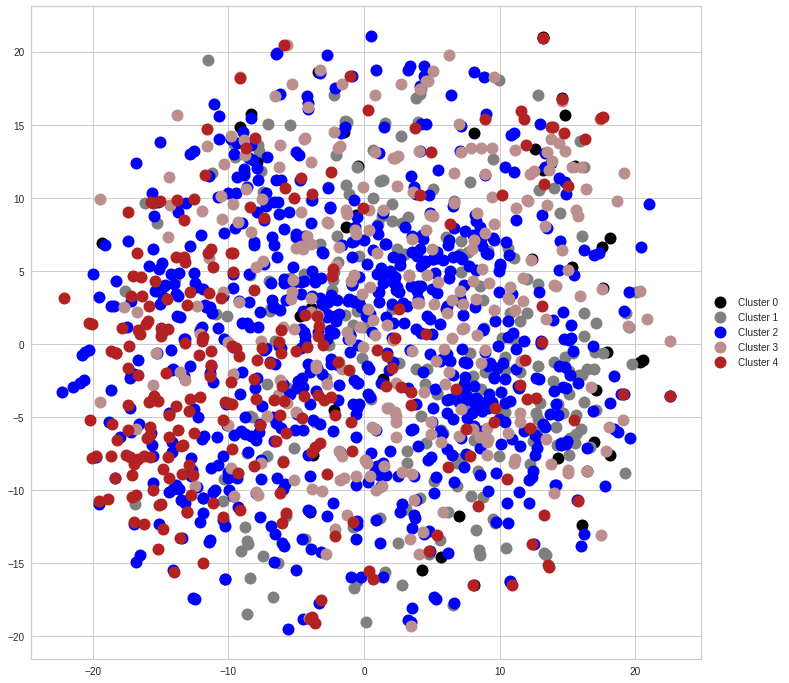

In [64]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

os.chdir('..') # return to working directory

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('tsne-document-clusters.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

pp.close()

## TF-IDF

In [65]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(tfidf_matrix.toarray())  # shape (n_components, n_samples)

In [66]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

os.chdir('..') # return to working directory

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('tsne-document-clusters.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

pp.close()

PermissionError: [Errno 13] Permission denied: 'tsne-document-clusters.pdf'

## Doc2Vec

In [69]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(doc2vec_100_vectors)  # shape (n_components, n_samples)

In [70]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

os.chdir('..') # return to working directory

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('tsne-document-clusters.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

pp.close()

PermissionError: [Errno 13] Permission denied: 'tsne-document-clusters.pdf'

# MDS Analysis

In [61]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(count_matrix.T.toarray())  # shape (n_components, n_samples)

In [62]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

os.chdir('..') # return to working directory

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('tsne-document-clusters.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

pp.close()

ValueError: arrays must all be same length